2등 코드 분석하기~!
==

In [3]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import cross_val_score
#clf = svm.SVC(kernel='linear', C=1)


from scipy.stats import uniform, randint

**load_breast_cancer, load_diabetes, load_win 분류와 관련된 데이터셋 로드** 

In [4]:
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine 
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

In [5]:
import xgboost as xgb
 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import rc, font_manager
rc('font',family="NanumSquareR")
from datetime import datetime
import featuretools as ft
from datetime import datetime
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import scipy.stats as st

**데이터셋 가져오기**

In [6]:
train=pd.read_csv("Auction_master_train_en.csv")
train=train.loc[train['Auction_key']!=10,]
test=pd.read_csv("Auction_master_test_en.csv")
regist=pd.read_csv("Auction_regist_en.csv")
rent=pd.read_csv("Auction_rent_en.csv")
result=pd.read_csv("Auction_result_en.csv")

**pandas 라이브러리의 corr 내장 매세드 사용해서 상관관계 분석 Method: Pearson**

In [7]:
train.corr()['Hammer_price'].sort_values()

Auction_key                   -0.494335
point.x                       -0.357186
Auction_count                 -0.060598
Auction_miscarriage_count     -0.059509
Total_land_gross_area          0.094260
Claim_price                    0.227550
Current_floor                  0.263951
Total_floor                    0.288378
point.y                        0.357915
Total_land_real_area           0.457389
Total_land_auction_area        0.470488
Total_building_area            0.644298
Total_building_auction_area    0.651966
Total_appraisal_price          0.976729
Minimum_sales_price            0.992170
Hammer_price                   1.000000
Name: Hammer_price, dtype: float64

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


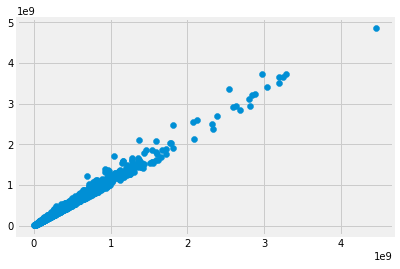

In [8]:
plt.scatter(train['Minimum_sales_price'],train['Hammer_price'])

**1. Corr을 이용한 상관관계 분석에서 Minimum sales price의 값이 Hammer_price의 상관관계가 너무 높아 다른 값들이 무시될 가능성이 우려되어 코드 작성자의 경우 Hammer_price / Minimum_sales_price 로 나누어서 비율에 대한 target 값으로 재설정 (이 과정에서 Hammer_price의 분산도 적어지게 됨.)**

In [9]:
train['real']=train['Hammer_price']/train['Minimum_sales_price']
test['real']=test['Hammer_price']/test['Minimum_sales_price']

findfont: Font family ['NanumSquareR'] not found. Falling back to DejaVu Sans.


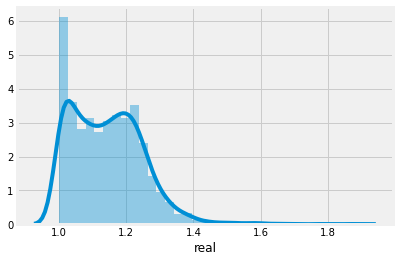

In [10]:
sns.distplot(train['real']) #histogram 생성

In [11]:
train.drop(['Hammer_price'],axis=1).corr()['real'].sort_values()

Auction_key                   -0.062983
Current_floor                 -0.055709
Total_floor                   -0.051553
Minimum_sales_price           -0.042232
point.x                       -0.039527
Total_land_gross_area          0.006978
Total_appraisal_price          0.020108
Total_building_area            0.025305
Total_building_auction_area    0.027848
point.y                        0.038295
Total_land_real_area           0.059067
Total_land_auction_area        0.060240
Claim_price                    0.104271
Auction_count                  0.356021
Auction_miscarriage_count      0.381825
real                           1.000000
Name: real, dtype: float64

**ratio에 대한 값으로 변경결과 상관관계가 매우 큰 값이 적어진 것을 볼 수 있음**

**2.건물 위치에 따른 hammer_price/Minimum_sales_price의 ratio heatmap만들기**

In [20]:
cop=train.copy()
cop['x']=pd.cut(train['point.x'],100) #100개의 동일한 크기의 bin 생성
cop['y']=pd.cut(train['point.y'],100)
cop1=cop.groupby(['x','y']).size().reset_index(name='count')
cop2=cop.groupby(['x','y'])['real'].mean().reset_index(name='real')
cop=pd.merge(cop1,cop2,on=['x','y'],how='left') #10000 x 4
cop

,x,y,count,real
0,"(126.807, 126.834]","(35.049, 35.078]",0,NaN
1,"(126.807, 126.834]","(35.078, 35.104]",0,NaN
2,"(126.807, 126.834]","(35.104, 35.13]",0,NaN
3,"(126.807, 126.834]","(35.13, 35.157]",0,NaN
4,"(126.807, 126.834]","(35.157, 35.183]",0,NaN
...,...,...,...,...
9995,"(129.231, 129.256]","(37.554, 37.58]",0,NaN
9996,"(129.231, 129.256]","(37.58, 37.607]",0,NaN
9997,"(129.231, 129.256]","(37.607, 37.633]",0,NaN
9998,"(129.231, 129.256]","(37.633, 37.659]",0,NaN


In [21]:
cop=cop.loc[cop['count']>=9] #88 x 4 filtering
cop

,x,y,count,real
95,"(126.807, 126.834]","(37.554, 37.58]",11,1.106657
193,"(126.834, 126.858]","(37.501, 37.528]",22,1.138617
194,"(126.834, 126.858]","(37.528, 37.554]",23,1.138008
195,"(126.834, 126.858]","(37.554, 37.58]",12,1.149220
292,"(126.858, 126.883]","(37.475, 37.501]",11,1.136653
...,...,...,...,...
9404,"(129.109, 129.134]","(35.157, 35.183]",25,1.170872
9405,"(129.109, 129.134]","(35.183, 35.209]",30,1.180296
9503,"(129.134, 129.158]","(35.13, 35.157]",10,1.085319
9604,"(129.158, 129.182]","(35.157, 35.183]",22,1.125366


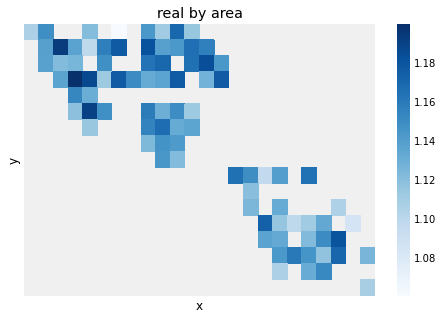

In [22]:
area = cop.pivot("y", "x", "real")
plt.subplots(1, 1, figsize=(7, 5))
plt.title("real by area")
sns.heatmap(area, annot=False, xticklabels=False,yticklabels=False,cmap="Blues")
plt.show()

**3.시계열데이터 처리**  
1.**daydiff1** =Close_date(종국일자)와 Final_acution_date(최종경매일) 간의 차  
2.**daydiff** =Appraisal_date(감정일자) 와 First_auction_date(최초경매일) 간의 차
3.**daydiff2** =최초경매일 과 최종경매일 간의 차

In [24]:
train['daydiff1']=(pd.to_datetime(train['Close_date'],errors='coerce') - pd.to_datetime(train['Final_auction_date'],errors='coerce')).dt.days
train['daydiff1']=np.where(train['daydiff1'].isnull(),train['daydiff1'].mean(),train['daydiff1'])

train['daydiff']=(pd.to_datetime(train['First_auction_date'],errors='coerce') - pd.to_datetime(train['Appraisal_date'],errors='coerce')).dt.days

train['daydiff']=np.where(train['daydiff'] < 0,train['daydiff'].median(),train['daydiff'])
train['daydiff2']=(pd.to_datetime(train['Final_auction_date'],errors='coerce')-pd.to_datetime(train['First_auction_date'],errors='coerce')).dt.days

In [26]:
test['daydiff1']=(pd.to_datetime(test['Close_date'],errors='coerce') - pd.to_datetime(test['Final_auction_date'],errors='coerce')).dt.days
test['daydiff1']=np.where(test['daydiff1'].isnull(),test['daydiff1'].mean(),test['daydiff1'])

test['daydiff']=(pd.to_datetime(test['First_auction_date'],errors='coerce') - pd.to_datetime(test['Appraisal_date'],errors='coerce')).dt.days

test['daydiff']=np.where(test['daydiff'] < 0,test['daydiff'].median(),test['daydiff'])
test['daydiff2']=(pd.to_datetime(test['Final_auction_date'],errors='coerce') - pd.to_datetime(test['First_auction_date'],errors='coerce')).dt.days

In [27]:
#Regist_date을 datetime 형태로 변환
regist['Regist_date']=pd.to_datetime(regist['Regist_date'].astype('str').str.slice(0,4)+"-"+regist['Regist_date'].astype('str').str.slice(4,6)+"-"+regist['Regist_date'].astype('str').str.slice(6,8),errors='coerce')

In [28]:
#Auction_date와 Rent_date를 datetime 형태로 변환
result['Auction_date']=pd.to_datetime(result['Auction_date'])
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')

In [32]:
#regist(등기부등본)에 써져 있는 등기 중 가장 일찍 등기된 것을 고른다 ==&gt; 가장 일찍 등기된 날짜가 건설작업완료 날짜의 추정치이다.
#built_date이라는 변수는 건설작업완료 추정 년도를, built_date1는 그 년도가 2000년을 넘기는지 아닌지를 가르키는 변수이다.
train['built_date']=train.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
train['built_date']=pd.DatetimeIndex(train['built_date']).year
train['built_date']=np.where(train['built_date'].isnull(),train['built_date'].median(),train['built_date'])

train['built_date1']=train['built_date']<=2000

test['built_date']=test.apply(lambda x: regist.loc[(regist['Auction_key']==x['Auction_key']),"Regist_date"].min(),axis=1)
test['built_date']=pd.DatetimeIndex(test['built_date']).year
test['built_date']=np.where(test['built_date'].isnull(),test['built_date'].median(),test['built_date'])

test['built_date1']=test['built_date']<=2000

**4.비율데이터 만들기**  
1."falld" =최저 경매가의 유찰시 낙폭에 따른 비율 함수만들기  
2. "lastup" =가장 마지막 이전의 최저경매가/총 평가액  

In [33]:
train['falld']=(train['Minimum_sales_price']/train['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

train['lastupp']=train.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)


test['falld']=(test['Minimum_sales_price']/test['Total_appraisal_price']).round(3)

a=pd.Series([0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])
b=pd.Series([0,0.134,0.168,0.21,0.262,0.328,0.41,0.512,0.64,0.8,1,1])

test['lastupp']=test.apply(lambda x: a[b==x['falld']].iloc[0],axis=1)

train['upp']=train['lastupp']/train['falld']
test['upp']=test['lastupp']/test['falld']

train['lastupp_p']=train['lastupp']*train['Total_appraisal_price']
test['lastupp_p']=test['lastupp']*test['Total_appraisal_price']

In [34]:
train['one']=train['Auction_miscarriage_count']==0
test['one']=test['Auction_miscarriage_count']==0

In [35]:
apartname=pd.Series(["더샵","자이","아이파크","래미안","힐스테이트"])

In [36]:
def get_apartname(string_val,apartname):
    if apartname.apply(lambda x: [x in y for y in [string_val]][0]).sum()>0:
        return np.asscalar(apartname.loc[apartname.apply(lambda x: [x in y for y in [string_val]][0])])
    else:
        return "other"

In [38]:
train['apart']=train.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)
test['apart']=test.apply(lambda x: get_apartname(string_val=x['addr_etc'],apartname=apartname),axis=1)
train['apart']

0       other
1       other
2       other
3       other
4       other
        ...  
1928    other
1929    other
1930    other
1931      래미안
1932       자이
Name: apart, Length: 1932, dtype: object

In [39]:
namecred=pd.Series(train['Creditor'].value_counts().head().index.tolist())
namecred

0    Company or Group
1             private
dtype: object

In [42]:
def getcred(string_val,namecred):
    if namecred.isin([string_val]).sum() > 0:
        return np.asscalar(namecred.loc[namecred.isin([string_val])])
    else:
        return "other"
        
train['cred']=train.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)
test['cred']=test.apply(lambda x: getcred(x['Creditor'],namecred=namecred),axis=1)
train['cred'].unique()

array(['Company or Group', 'private'], dtype=object)

In [43]:
#경매에서 권리의 인수여부는 말소기준권리를 기준으로 결정된다.
#말소기준권리는 저당,압류, 가압 중에서 가장 먼저 일어난 것이며, 각각의 Auction_key마다 이것을 찾아 malsogijun이라는 데이터프레임을 만들었다.
regist['Regist_class']=regist['Regist_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_class']=rent['Rent_class'].astype('str').str.replace(pat=" ",repl="").astype('str')
rent['Rent_date']=pd.to_datetime(rent['Rent_date'],errors='coerce')
malsogijun=regist.loc[pd.Series(regist['Regist_class']).isin(["저당","압류","가압"]),].groupby(['Auction_key'])['Regist_date'].min().reset_index()

In [44]:
#이 말소기준보다 전에 일어나고 점유하고 있는 임차인(대항력을 가진 임차인)을 찾아 해당 경매의 낙찰자가 인수해야 할 Rent_deposit을 take_over_rent라는 변수에 저장한다
def get_rent_malso(Rent_date,Auction_key,Rent_class):
    #if pd.isnull(Rent_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
    #    return np.nan
    #else:
    return (#np.asscalar((Rent_date&lt;malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (Rent_class=="점유"))



k=rent.apply(lambda x: get_rent_malso(Rent_date=x['Rent_date'],Auction_key=x['Auctiuon_key'],Rent_class=x['Rent_class']),axis=1)

rent['k']=k
k=rent.loc[rent['k']==True,].groupby(['Auctiuon_key'])['Rent_deposit'].sum().reset_index()
k.columns=['Auction_key','take_over_rent']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_rent']=np.where(train['take_over_rent'].isnull(),0,train['take_over_rent'])
test['take_over_rent']=np.where(test['take_over_rent'].isnull(),0,test['take_over_rent'])

In [46]:
#등기부등본 상에서도 말소기준 권리 이전에 일어난 모든 권리행위의 Regist_price를 더해 take_over_regist라는 변수를 만든다.
def get_regist_malso(Regist_date,Auction_key,Regist_class):
        if pd.isnull(Regist_date) or len((malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]))==0:
            return np.nan
        else:
            return (np.asscalar((Regist_date<malsogijun.loc[malsogijun['Auction_key']==Auction_key,"Regist_date"]).values) &
                           (pd.Series(Regist_class).isin(["전세권","임차권","가등기"])))



k=regist.apply(lambda x: get_regist_malso(Regist_date=x['Regist_date'],Auction_key=x['Auction_key'],Regist_class=x['Regist_class']),axis=1)

regist['k']=k
k=regist.loc[regist['k']==True,].groupby(['Auction_key'])['Regist_price'].sum().reset_index()
k.columns=['Auction_key','take_over_regist']
train=pd.merge(train,k,how='left')
test=pd.merge(test,k,how='left')

train['take_over_regist']=np.where(train['take_over_regist'].isnull(),0,train['take_over_regist'])
test['take_over_regist']=np.where(test['take_over_regist'].isnull(),0,test['take_over_regist'])

In [47]:
train['take_over_sum']=train['take_over_regist']+train['take_over_rent']
test['take_over_sum']=test['take_over_regist']+test['take_over_rent']

In [48]:
a=regist.apply(lambda x: pd.Series(x['Regist_class']).isin(['전세권','가등기','임차권']),axis=1)
a.columns=['a']

regist1=regist.loc[a['a'],]

def get_badang(Auction_key,a=regist1):
    return len(a.loc[a['Auction_key']==Auction_key,])
    
train['badang']=train.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)
test['badang']=test.apply(lambda x: get_badang(x['Auction_key'],a=regist1),axis=1)

In [49]:
train['is_rent']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
test['is_rent']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(rent['Auctiuon_key'])),axis=1)
train['is_regist']=train.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)
test['is_regist']=test.apply(lambda x: pd.Series(x['Auction_key']).isin(list(regist['Auction_key'])),axis=1)

In [50]:
#regist나 rent에 대한 정보가 있는 것이 오히려 real값이 적어지는 경향이 있는 것을 알 수 있다.
train['floor_rate']=train['Current_floor']/train['Total_floor']
test['floor_rate']=test['Current_floor']/test['Total_floor']

In [52]:
#해당 방의 층을 아파트의 전체 층으로 나눈 층의 비율을 floor_rate 라는 변수로 만듦.
#아파트마다 층이 다르므로, 이를 비교하기위한 normalization 과정이라 할 수 있다.
result1=result.loc[result['Auction_results']=="낙찰",]

a=result1.groupby(['Auction_key'])['Auction_results'].count().reset_index()
a['Auction_results']=a['Auction_results']>1
a.columns=['Auction_key','is_re']
train=pd.merge(train,a,how='left')
test=pd.merge(test,a,how='left')

In [53]:
seoul=pd.read_csv("seoul_price.csv",engine="python")
busan=pd.read_csv("busan_price.csv",engine="python")

FileNotFoundError: [Errno 2] No such file or directory: 'seoul_price.csv'

In [ ]:
#seoul과 busan의 Unnamed: 0이라는 column을 datetime 형태로 바꾸는 작업을 한다.

seoul['Unnamed: 0']=seoul['Unnamed: 0'].astype('str').str.replace(pat="'",repl="")
seoul['Unnamed: 0']=seoul['Unnamed: 0'].astype('str').str.replace(pat="\\.",repl="-")
seoul['Unnamed: 0']="20"+seoul['Unnamed: 0']+"-01"
seoul['Unnamed: 0']=pd.to_datetime(seoul['Unnamed: 0'])

busan['Unnamed: 0']=busan['Unnamed: 0'].astype('str').str.replace(pat="'",repl="")
busan['Unnamed: 0']=busan['Unnamed: 0'].astype('str').str.replace(pat="\\.",repl="-")
busan['Unnamed: 0']="20"+busan['Unnamed: 0']+"-01"
busan['Unnamed: 0']=pd.to_datetime(busan['Unnamed: 0'])

In [ ]:
def get_expectp1(x,data):
    y=pd.DatetimeIndex(data['Appraisal_date']).year[x]
    m=pd.DatetimeIndex(data['Appraisal_date']).month[x]
    y1=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m1=pd.DatetimeIndex(data['Final_auction_date']).month[x]
    if(data['addr_do'].iloc[x]=="부산"):
        k=busan
    else:
        k=seoul
    
    k=k[['Unnamed: 0',data['addr_si'].iloc[x]]]
    

    result1=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y1) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m1),data['addr_si'].iloc[x]  ]
        
    result2=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m),data['addr_si'].iloc[x]  ]      
    if(len(result2)==0):
        return np.nan
    else:
        return np.asscalar(result1)/np.asscalar(result2)

In [ ]:
train['p_first']=train.apply(lambda x: get_expectp1(x.name,data=train),axis=1)
train['p_first']=np.where(train['p_first'].isnull(),(train['p_first']).mean(),train['p_first'])

test['p_first']=test.apply(lambda x: get_expectp1(x.name,data=test),axis=1)
test['p_first']=np.where(test['p_first'].isnull(),(test['p_first']).mean(),test['p_first'])

train['p_first_rat']=train['p_first']*train['Total_appraisal_price']/train['Minimum_sales_price']
test['p_first_rat']=test['p_first']*test['Total_appraisal_price']/test['Minimum_sales_price']

train['rat_sub_to1']=train['p_first_rat']-train['take_over_sum']/train['Minimum_sales_price']
test['rat_sub_to1']=test['p_first_rat']-test['take_over_sum']/test['Minimum_sales_price']

In [ ]:
from tqdm import tqdm

result_df = pd.DataFrame()
for i, df in tqdm(result.groupby('Auction_key')):
    result_df.loc[i, 'Auction_key'] = int(df['Auction_key'].values[0])
    result_df.loc[i, 'nac'] = (df['Auction_results'] == '낙찰').sum()
    result_df.loc[i, 'bae'] = (df['Auction_results'] == '배당').sum()
    result_df.loc[i, 'you'] = (df['Auction_results'] == '유찰').sum()
    result_df.loc[i, 'byun'] = (df['Auction_results'] == '변경').sum()
    result_df.loc[i, 'dae'] = (df['Auction_results'] == '대납').sum()
    result_df.loc[i, 'nacrat'] = (df['Auction_results'] == '낙찰').mean()
    result_df.loc[i, 'baerat'] = (df['Auction_results'] == '배당').mean()
    result_df.loc[i, 'yourat'] = (df['Auction_results'] == '유찰').mean()
    result_df.loc[i, 'byunrat'] = (df['Auction_results'] == '변경').mean()
    result_df.loc[i, 'daerat'] = (df['Auction_results'] == '대납').mean()
    result_df.loc[i, 'maxres'] = df['Auction_results'].value_counts().index[0]
    result_df.loc[i, 'maxnum'] = df['Auction_results'].value_counts()[0]
    result_df.loc[i, 'maxrat'] = (df['Auction_results'].value_counts()/df['Auction_results'].value_counts().sum())[0]

In [ ]:
train = train.merge(result_df, how='left', on='Auction_key')
test = test.merge(result_df, how='left', on='Auction_key')

In [ ]:
def get_trend(x,data):
    y=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m=pd.DatetimeIndex(data['Final_auction_date']).month[x]-1
    
    if m&lt;=0:
        y=pd.DatetimeIndex(data['Final_auction_date']).year[x]-1
        m=12
    
    y1=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m1=pd.DatetimeIndex(data['Final_auction_date']).month[x]

    if data['addr_do'].iloc[x]=="부산":
        k=busan
    else:
        k=seoul
    
    k=k[['Unnamed: 0',data['addr_si'].iloc[x]]]
    
    result1=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y1) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m1),data['addr_si'].iloc[x]  ]
        
    result2=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m),data['addr_si'].iloc[x]  ]      

    return np.asscalar(result1)/np.asscalar(result2)

In [ ]:
train['trend']=train.apply(lambda x: get_trend(x.name,data=train),axis=1)
test['trend']=test.apply(lambda x: get_trend(x.name,data=test),axis=1)

In [ ]:
def get_trend1(x,data):
    a=result.loc[(result['Auction_key']==data['Auction_key'].iloc[x]) & (result['Auction_results']=="유찰"),]
    a=a['Auction_date'].max()
    
    y=np.asscalar(pd.DatetimeIndex(pd.Series([a])).year)
    m=np.asscalar(pd.DatetimeIndex(pd.Series([a])).month)
    
    y1=pd.DatetimeIndex(data['Final_auction_date']).year[x]
    m1=pd.DatetimeIndex(data['Final_auction_date']).month[x]

    if np.asscalar(pd.Series(y).isnull()):
        y=y1
        m=m1
    
    if data['addr_do'].iloc[x]=="부산":
        k=busan
    else:
        k=seoul
        
        
    k=k[['Unnamed: 0',data['addr_si'].iloc[x]]]
    
    result1=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y1) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m1),data['addr_si'].iloc[x]  ]
        
    result2=k.loc[  (pd.DatetimeIndex(k['Unnamed: 0']).year==y) & 
                    (pd.DatetimeIndex(k['Unnamed: 0']).month==m),data['addr_si'].iloc[x]  ]      
    
    if(len(result2)==0):
        return np.nan
    else:
        return np.asscalar(result1)/np.asscalar(result2)

In [ ]:
train['trend_first_fin']=train.apply(lambda x: get_trend1(x.name,data=train),axis=1)
test['trend_first_fin']=test.apply(lambda x: get_trend1(x.name,data=test),axis=1)
train['trend_first_fin']=np.where(train['trend_first_fin'].isnull(),train['trend_first_fin'].mean(),train['trend_first_fin'])
test['trend_first_fin']=np.where(test['trend_first_fin'].isnull(),test['trend_first_fin'].mean(),test['trend_first_fin'])

In [ ]:
newdf=pd.read_excel("2010-2013송근일.xlsx")
newdf=pd.concat([newdf,pd.read_csv("external_data_2014_2018 (1).csv",engine="python")],axis=0)
newdf=newdf.drop(['번지'],axis=1)

In [ ]:
newdf=newdf.drop_duplicates()
a=newdf['계약일'].str.split("~",expand=True)
a.columns=['a','b']
newdf['days']=(a['a'].astype('int64')/2+a['b'].astype('int64')/2).astype('int64')
newdf['addr_bunji']=newdf['본번'].astype('str')+"-"+newdf['부번'].astype('str')
newdf=newdf.drop(['본번','부번','계약일'],axis=1)
a=newdf['시군구'].str.split(" ",expand=True)
a.columns=['a','addr_si','addr_dong','b']
a=a.drop(['a','b'],axis=1)
newdf['addr_sidong']=a['addr_si']+" "+a['addr_dong']
newdf=newdf.drop(['시군구'],axis=1)
train.loc[train['addr_bunji2'].isnull(),'addr_bunji2']=0
train.loc[~train['addr_bunji1'].isnull(),'addr_bunji']=train.loc[~train['addr_bunji1'].isnull(),'addr_bunji1'].astype('int64').astype('str')+"-"+train.loc[~train['addr_bunji1'].isnull(),'addr_bunji2'].astype('int64').astype('str')
train.loc[train['addr_bunji1'].isnull(),'addr_bunji']=np.nan

test.loc[test['addr_bunji2'].isnull(),'addr_bunji2']=0
test.loc[~test['addr_bunji1'].isnull(),'addr_bunji']=test.loc[~test['addr_bunji1'].isnull(),'addr_bunji1'].astype('int64').astype('str')+"-"+test.loc[~test['addr_bunji1'].isnull(),'addr_bunji2'].astype('int64').astype('str')
test.loc[test['addr_bunji1'].isnull(),'addr_bunji']=np.nan

newdf['year']=newdf['계약년월'].astype('str').str.slice(0,4)
newdf['month']=newdf['계약년월'].astype('str').str.slice(4,6)
newdf=newdf.drop(['계약년월'],axis=1)

train['addr_sidong']=train['addr_si']+" "+train['addr_dong']
test['addr_sidong']=test['addr_si']+" "+test['addr_dong']

newdf['tr_date']=newdf['year'].astype('str')+"-"+newdf['month'].astype('str')+"-"+newdf['days'].astype('str')
newdf=newdf.drop(['month','year','days'],axis=1)

newdf['tr_date']=newdf['tr_date'].astype('str')
newdf['tr_date']=newdf['tr_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

train['Final_auction_date']=train['Final_auction_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
train['Appraisal_date']=train['Appraisal_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
train['First_auction_date']=train['First_auction_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

test['Final_auction_date']=test['Final_auction_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
test['Appraisal_date']=test['Appraisal_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
test['First_auction_date']=test['First_auction_date'].astype('str').str.slice(0,10).apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
newdf['거래금액(만원)']=newdf['거래금액(만원)'].astype('str').str.replace(pat=",",repl="").astype('float')
newdf.columns=['dan_name','Total_building_auction_area','price','Current_floor','built_date','road_name','addr_bunji','addr_sidong','tr_date']
a=newdf['addr_sidong'].str.split(" ",expand=True)
a.columns=['a','b']
newdf['addr_si']=a['a']
newdf['position']=newdf['addr_sidong'].astype('str')+newdf['addr_bunji'].astype('str')
train['position']=train['addr_sidong'].astype('str')+train['addr_bunji'].astype('str')
test['position']=test['addr_sidong'].astype('str')+test['addr_bunji'].astype('str')

In [ ]:
def getprice_by_bunji_finaldate(i,area_diff=5,data=train,method="mean"):
    a=pd.DatetimeIndex(newdf['tr_date']).year.isin([pd.DatetimeIndex(data['Final_auction_date']).year[i]])
    #a=pd.DatetimeIndex(data['Final_auction_date']).year[i]==pd.DatetimeIndex(newdf['tr_date']).year
    b=pd.DatetimeIndex(newdf['tr_date']).month.isin([pd.DatetimeIndex(data['Final_auction_date']).month[i]])
    
    c=newdf['position'].isin([data['position'].iloc[i]])
    #d=newdf['addr_bunji'].isin([data['addr_bunji'].iloc[i]])
    d=(data['Total_building_auction_area'].iloc[i]-newdf['Total_building_auction_area']).abs()&lt;=area_diff
    final_cond=a & b & c & d
    if (i+1)%100==0:
        print(i+1)
    if(method=="mean"):
        return newdf.loc[final_cond,"price"].mean()
    elif(method=="median"):
        return newdf.loc[final_cond,"price"].median()
    elif(method=="linear_regression"):
        x=pd.DataFrame(newdf.loc[(newdf['addr_si']==train['addr_si'][i]) &(pd.DatetimeIndex(data['Final_auction_date']).year[i]==pd.DatetimeIndex(newdf['tr_date']).year),'Current_floor'])
        y=pd.Series(newdf.loc[(newdf['addr_si']==train['addr_si'][i]) &(pd.DatetimeIndex(data['Final_auction_date']).year[i]==pd.DatetimeIndex(newdf['tr_date']).year),'price'])
        lr=LinearRegression().fit(x,y)
        return ((lr.coef_/3*(train['Current_floor'].iloc[i]-newdf.loc[final_cond,"Current_floor"].median())+newdf.loc[final_cond,"price"].median()).astype('float'))

In [ ]:
def price_(i,data=train,floor_diff=10,daydiff=100):
    a=newdf['position'].isin([data['position'].iloc[i]])
    #b=newdf['addr_sidong'].isin([data['addr_sidong'].iloc[i]])
    #a=data['addr_bunji'].iloc[i]==newdf['addr_bunji']
    #b=data['addr_sidong'].iloc[i]==newdf['addr_sidong']
    b=(data['Total_building_auction_area'].iloc[i]-newdf['Total_building_auction_area']).abs()&lt;=5
    c=(data['Current_floor'].iloc[i]-newdf['Current_floor']).abs()&lt;=floor_diff
    d=(newdf['tr_date']-data['Final_auction_date'].iloc[i]).abs().dt.days&lt;=daydiff
    final_cond=a & b & c & d
    k=newdf.loc[final_cond,]
    if (i+1)%100==0:
        print(i+1)
    if(len(k)==0):
        return np.nan
    else:
        return k['price'].mean()#(k.loc[(k['tr_date']-data['Final_auction_date'].iloc[i]).abs().min()==(k['tr_date']-data['Final_auction_date'].iloc[i]).abs(),"price"]).mean()
    #return median(newdf.loc[(newdf.loc[final_cond,"tr_date"]-data['Appraisal_date']).min()==newdf[,'tr_date'],"price"])
    #if(method=="mean"):
    #return newdf.loc[(a & b & c),"price"],mean()

In [ ]:
def price_prev(i,data=train,floor_diff=10,big=3):
    a=newdf['position'].isin([data['position'].iloc[i]])
    #b=newdf['addr_sidong'].isin([data['addr_sidong'].iloc[i]])
    b=(data['Total_building_auction_area'].iloc[i]-newdf['Total_building_auction_area']).abs()&lt;=5
    c=(data['Current_floor'].iloc[i]-newdf['Current_floor']).abs()&lt;=floor_diff
    d=(data['Final_auction_date'].iloc[i]-newdf['tr_date']).dt.days&gt;0
    final_cond=a & b & c & d
    k=newdf.loc[final_cond,]
    k1=(k['tr_date'])
    if (i+1)%100==0:
        print(i+1)
    return (k.loc[k1.isin(k1.nlargest(big)),"price"]).mean()


def price_post(i,data=train,floor_diff=10,small=3):
    #df[df['categories'].map(lambda x: x in string.ascii_lowercase)]
    #df[df['categories'].isin(list(string.ascii_lowercase))]
    a=newdf['position'].isin([data['position'].iloc[i]])
    #a=newdf['addr_bunji'].map(lambda x: x in data['addr_bunji'].iloc[i])
    #b=newdf['addr_sidong'].isin([data['addr_sidong'].iloc[i]])
    #b=newdf['addr_sidong'].map(lambda x: x in data['addr_sidong'].iloc[i])
    #a=data['addr_bunji'].iloc[i]==newdf['addr_bunji']
    #b=data['addr_sidong'].iloc[i]==newdf['addr_sidong']
    b=(data['Total_building_auction_area'].iloc[i]-newdf['Total_building_auction_area']).abs()&lt;=5
    c=(data['Current_floor'].iloc[i]-newdf['Current_floor']).abs()&lt;=floor_diff
    d=(data['Final_auction_date'].iloc[i]-newdf['tr_date']).dt.days&lt;0
    final_cond=a & b & c & d
    k=newdf.loc[final_cond,]
    k1=(k['tr_date'])
    if (i+1)%100==0:
        print(i+1)
    return (k.loc[k1.isin(k1.nsmallest(small)),"price"]).mean()

In [ ]:
for i in [1,5]:
    train['p_post: '+str(i)+', '+str(10)]=train.apply(lambda x: price_post(i=x.name,small=i,floor_diff=10),axis=1)
    train['p_prev: '+str(i)+', '+str(10)]=train.apply(lambda x: price_prev(i=x.name,big=i,floor_diff=10),axis=1)

In [ ]:
for i in [5,10,50,100]:
    train['bunji with: '+str(i)]=train.apply(lambda x: getprice_by_bunji_finaldate(i=x.name,area_diff=i),axis=1)

In [ ]:
for i in [1,5]:
    test['p_post: '+str(i)+', '+str(10)]=test.apply(lambda x: price_post(i=x.name,small=i,floor_diff=10,data=test),axis=1)
    test['p_prev: '+str(i)+', '+str(10)]=test.apply(lambda x: price_prev(i=x.name,big=i,floor_diff=10,data=test),axis=1)

In [ ]:
for i in [5,10,50,100]:
    test['bunji with: '+str(i)]=test.apply(lambda x: getprice_by_bunji_finaldate(i=x.name,area_diff=i,data=test),axis=1)

In [ ]:
train['p_prev: 1, 10']=np.where(train['p_prev: 1, 10'].isnull(),train['p_post: 1, 10'],train['p_prev: 1, 10'])
#train['p_prev: 1, 10']=np.where(train['p_prev: 1, 10'].isnull(),train['bunji with: 5'],train['p_prev: 1, 10'])
train['p_prev: 1, 10']=np.where(train['p_prev: 1, 10'].isnull(),train['Minimum_sales_price']*train['p_first_rat']/10000,train['p_prev: 1, 10'])


train['p_prev: 5, 10']=np.where(train['p_prev: 5, 10'].isnull(),train['p_post: 5, 10'],train['p_prev: 5, 10'])
#train['p_prev: 5, 10']=np.where(train['p_prev: 5, 10'].isnull(),train['bunji with: 5'],train['p_prev: 5, 10'])
train['p_prev: 5, 10']=np.where(train['p_prev: 5, 10'].isnull(),train['Minimum_sales_price']*train['p_first_rat']/10000,train['p_prev: 5, 10'])


#train['p_prev: 10, 10']=np.where(train['p_prev: 10, 10'].isnull(),train['p_post: 10, 10'],train['p_prev: 10, 10'])
#train['p_prev: 10, 10']=np.where(train['p_prev: 10, 10'].isnull(),train['bunji with: 5'],train['p_prev: 10, 10'])
#train['p_prev: 10, 10']=np.where(train['p_prev: 10, 10'].isnull(),train['Minimum_sales_price']*train['p_first_rat']/10000,train['p_prev: 10, 10'])



train['p_post: 1, 10']=np.where(train['p_post: 1, 10'].isnull(),train['p_prev: 1, 10'],train['p_post: 1, 10'])
train['p_post: 5, 10']=np.where(train['p_post: 5, 10'].isnull(),train['p_prev: 5, 10'],train['p_post: 5, 10'])
#train['p_post: 10, 10']=np.where(train['p_post: 10, 10'].isnull(),train['p_prev: 10, 10'],train['p_post: 10, 10'])

test['p_prev: 1, 10']=np.where(test['p_prev: 1, 10'].isnull(),test['p_post: 1, 10'],test['p_prev: 1, 10'])
#test['p_prev: 1, 10']=np.where(test['p_prev: 1, 10'].isnull(),test['bunji with: 5'],test['p_prev: 1, 10'])
test['p_prev: 1, 10']=np.where(test['p_prev: 1, 10'].isnull(),test['Minimum_sales_price']*test['p_first_rat']/10000,test['p_prev: 1, 10'])


test['p_prev: 5, 10']=np.where(test['p_prev: 5, 10'].isnull(),test['p_post: 5, 10'],test['p_prev: 5, 10'])
#test['p_prev: 5, 10']=np.where(test['p_prev: 5, 10'].isnull(),test['bunji with: 5'],test['p_prev: 5, 10'])
test['p_prev: 5, 10']=np.where(test['p_prev: 5, 10'].isnull(),test['Minimum_sales_price']*test['p_first_rat']/10000,test['p_prev: 5, 10'])


#test['p_prev: 10, 10']=np.where(test['p_prev: 10, 10'].isnull(),test['p_post: 10, 10'],test['p_prev: 10, 10'])
#test['p_prev: 10, 10']=np.where(test['p_prev: 10, 10'].isnull(),test['bunji with: 5'],test['p_prev: 10, 10'])
#test['p_prev: 10, 10']=np.where(test['p_prev: 10, 10'].isnull(),test['Minimum_sales_price']*test['p_first_rat']/10000,test['p_prev: 10, 10'])


test['p_post: 1, 10']=np.where(test['p_post: 1, 10'].isnull(),test['p_prev: 1, 10'],test['p_post: 1, 10'])
test['p_post: 5, 10']=np.where(test['p_post: 5, 10'].isnull(),test['p_prev: 5, 10'],test['p_post: 5, 10'])
#test['p_post: 10, 10']=np.where(test['p_post: 10, 10'].isnull(),test['p_prev: 10, 10'],test['p_post: 10, 10'])

In [ ]:
train['bunji with: 5']=np.where(train['bunji with: 5'].isnull(),train['p_prev: 5, 10'],train['bunji with: 5'])
train['bunji with: 10']=np.where(train['bunji with: 10'].isnull(),train['p_prev: 5, 10'],train['bunji with: 10'])
train['bunji with: 50']=np.where(train['bunji with: 50'].isnull(),train['p_prev: 5, 10'],train['bunji with: 50'])
train['bunji with: 100']=np.where(train['bunji with: 100'].isnull(),train['p_prev: 5, 10'],train['bunji with: 100'])

test['bunji with: 5']=np.where(test['bunji with: 5'].isnull(),test['p_prev: 5, 10'],test['bunji with: 5'])
test['bunji with: 10']=np.where(test['bunji with: 10'].isnull(),test['p_prev: 5, 10'],test['bunji with: 10'])
test['bunji with: 50']=np.where(test['bunji with: 50'].isnull(),test['p_prev: 5, 10'],test['bunji with: 50'])
test['bunji with: 100']=np.where(test['bunji with: 100'].isnull(),test['p_prev: 5, 10'],test['bunji with: 100'])

In [ ]:
train['p_prev: 1, 10']=train['p_prev: 1, 10']/train['Minimum_sales_price']*10000
train['p_prev: 5, 10']=train['p_prev: 5, 10']/train['Minimum_sales_price']*10000
#train['p_prev: 10, 10']=train['p_prev: 10, 10']/train['Minimum_sales_price']*10000

train['p_post: 1, 10']=train['p_post: 1, 10']/train['Minimum_sales_price']*10000
train['p_post: 5, 10']=train['p_post: 5, 10']/train['Minimum_sales_price']*10000
#train['p_post: 10, 10']=train['p_post: 10, 10']/train['Minimum_sales_price']*10000

train['bunji with: 5']=train['bunji with: 5']/train['Minimum_sales_price']*10000
train['bunji with: 10']=train['bunji with: 10']/train['Minimum_sales_price']*10000
train['bunji with: 50']=train['bunji with: 50']/train['Minimum_sales_price']*10000
train['bunji with: 100']=train['bunji with: 100']/train['Minimum_sales_price']*10000

test['p_prev: 1, 10']=test['p_prev: 1, 10']/test['Minimum_sales_price']*10000
test['p_prev: 5, 10']=test['p_prev: 5, 10']/test['Minimum_sales_price']*10000
#test['p_prev: 10, 10']=test['p_prev: 10, 10']/test['Minimum_sales_price']*10000

test['p_post: 1, 10']=test['p_post: 1, 10']/test['Minimum_sales_price']*10000
test['p_post: 5, 10']=test['p_post: 5, 10']/test['Minimum_sales_price']*10000
#test['p_post: 10, 10']=test['p_post: 10, 10']/test['Minimum_sales_price']*10000

test['bunji with: 5']=test['bunji with: 5']/test['Minimum_sales_price']*10000
test['bunji with: 10']=test['bunji with: 10']/test['Minimum_sales_price']*10000
test['bunji with: 50']=test['bunji with: 50']/test['Minimum_sales_price']*10000
test['bunji with: 100']=test['bunji with: 100']/test['Minimum_sales_price']*10000

In [ ]:
train=train.drop(['addr_bunji','addr_sidong','position'],axis=1)
test=test.drop(['addr_bunji','addr_sidong','position'],axis=1)

train=train.drop(['road_name','addr_etc','First_auction_date','Appraisal_date','addr_si','addr_dong','addr_li','addr_san'],axis=1)
test=test.drop(['road_name','addr_etc','First_auction_date','Appraisal_date','addr_si','addr_dong','addr_li','addr_san'],axis=1)

train=train.drop(['Creditor','Specific','Appraisal_company','Close_result','Final_result'],axis=1)
test=test.drop(['Creditor','Specific','Appraisal_company','Close_result','Final_result'],axis=1)


from datetime import datetime
today = datetime.today()

train['diff_today_final_date'] = (pd.to_datetime(train['Final_auction_date']) - today).dt.days
#test['diff_today_appraisal_date'] = (pd.to_datetime(df_test['Appraisal_date']) - today).astype(int)
train=train.drop(['Final_auction_date','Close_date','Preserve_regist_date'],axis=1)


test['diff_today_final_date'] = (pd.to_datetime(test['Final_auction_date']) - today).dt.days
test=test.drop(['Final_auction_date','Close_date','Preserve_regist_date'],axis=1)


le = LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) &lt;= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print(le_count)

train = pd.get_dummies(train)


le = LabelEncoder()
le_count = 0

for col in test:
    if test[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(test[col].unique())) &lt;= 2:
            # Train on the training data
            le.fit(test[col])
            # Transform both training and testing data
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
print(le_count)

test = pd.get_dummies(test)
train=train.drop(['addr_bunji1','addr_bunji2','road_bunji1','road_bunji2'],axis=1)
test=test.drop(['addr_bunji1','addr_bunji2','road_bunji1','road_bunji2'],axis=1)

In [ ]:
import lightgbm as lgb
def get_oof_lgbm(params, train_data, test_data, target_data, num_round, early_round, verbose_round, N_SPLITS=5, random_state=0):

    FOLDs=KFold(n_splits=N_SPLITS, shuffle=True,random_state=0)

    oof = np.zeros(len(train_data))
    predictions = np.zeros(len(test_data))

    features_lgb = list(train_data.columns)
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train_data)):
        trn_data = lgb.Dataset(train_data.iloc[trn_idx], label=target_data.iloc[trn_idx])
        val_data = lgb.Dataset(train_data.iloc[val_idx], label=target_data.iloc[val_idx])

        print("LGB " + str(fold_) + "-" * 50)
        num_round = num_round
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=verbose_round, 
                        early_stopping_rounds = early_round)
        oof[val_idx] = clf.predict(train_data.iloc[val_idx], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features_lgb
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        predictions += clf.predict(test_data, num_iteration=clf.best_iteration) / FOLDs.n_splits
    return oof, predictions, feature_importance_df

In [ ]:
import xgboost as xgb
def get_oof_xgb(params, train_data, test_data, target_data, num_round, early_round, verbose_round, N_SPLITS=5, random_state=0):

    FOLDs=KFold(n_splits=N_SPLITS, shuffle=True,random_state=0)

    oof = np.zeros(len(train_data))
    predictions = np.zeros(len(test_data))

    feature_importance_df = pd.DataFrame()

    best_iters = []
    for fold_, (trn_idx, val_idx) in enumerate(FOLDs.split(train_data)):
        trn_data = xgb.DMatrix(train_data.iloc[trn_idx], label=target_data.iloc[trn_idx])
        val_data = xgb.DMatrix(train_data.iloc[val_idx], label=target_data.iloc[val_idx])

#         print("xgb " + str(fold_) + "-" * 50)

        watchlist = [(trn_data, 'train'), (val_data, 'valid')]
#         print("xgb " + str(fold_) + "-" * 50)
        num_round = num_round
        xgb_model = xgb.train(params, trn_data, num_round, watchlist, 
                              early_stopping_rounds=early_round, verbose_eval=verbose_round)
        oof[val_idx] = xgb_model.predict(xgb.DMatrix(train_data.iloc[val_idx]), 
                                             ntree_limit=xgb_model.best_ntree_limit)

        predictions += xgb_model.predict(xgb.DMatrix(test_data), 
                                             ntree_limit=xgb_model.best_ntree_limit) / FOLDs.n_splits
        
        fold_importance_df = pd.DataFrame([xgb_model.get_score()]).T.reset_index()
        fold_importance_df.columns = ['feature', 'importance']
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        best_iters.append(xgb_model.best_ntree_limit)
    return oof, predictions, feature_importance_df, np.mean(best_iters)

In [ ]:
input_var_names = [f for f in train if f not in ['maxres_대납','addr_dong_count','addr_dong_mean','Creditor_nunique','Creditor_entropy','private_rate','road_bunji2_NA','addr_bunji2_NA','real','Auction_miscarriage_count','Hammer_price','Auction_key','addr_bunji1','addr_bunji2','road_bunji1','road_bunji2']]#,'you','yourat','point.x','point.y']]
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_features=28)
X=train[input_var_names]
y=train['real']
X_1=test[input_var_names]
y_1=test['real']#print(1)
rf.fit(X, y)#,sample_weight=train1['weights'])
predictions_rf1 = rf.predict(X_1)*X_1['Minimum_sales_price']

In [ ]:
input_var_names = [f for f in train if f not in ['maxres_대납','addr_dong_count','addr_dong_mean','Creditor_nunique','Creditor_entropy','private_rate','road_bunji2_NA','addr_bunji2_NA','real','Auction_miscarriage_count','Hammer_price','Auction_key','addr_bunji1','addr_bunji2','road_bunji1','road_bunji2']]#,'you','yourat','point.x','point.y']]
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
X=train[input_var_names]
y=train['real']
X_1=test[input_var_names]
y_1=test['real']#print(1)
rf.fit(X, y)#,sample_weight=train1['weights'])
predictions_rf2 = rf.predict(X_1)*X_1['Minimum_sales_price']

In [ ]:
import lightgbm as lgb
xgb_params={"objective":"regression",
           "metric":"rmse",
           "max_depth":6,
           "min_child_samples":2,
           "alpha":0.08,
           "gamma":0.06,
           "eta":0.04,
           "subsample":0.08,
           "colsample_bytree":0.97,
           "silent":True}
a,b,c=get_oof_lgbm(xgb_params, X, X_1, y, num_round=100000, early_round=400, verbose_round=500, N_SPLITS=5, random_state=0)

predictions_lgbm=b*test['Minimum_sales_price']

In [ ]:
input_var_names = [f for f in train if f not in ['maxres_대납','bunji with: 5','bunji with: 10','bunji with: 50','addr_dong_count','addr_dong_mean','Creditor_nunique','Creditor_entropy','private_rate','road_bunji2_NA','addr_bunji2_NA','real','Auction_miscarriage_count','Hammer_price','Auction_key','addr_bunji1','addr_bunji2','road_bunji1','road_bunji2']]#,'you','yourat','point.x','point.y']]
X=train[input_var_names]
y=train['real']
X_1=test[input_var_names]
y_1=test['real']#print(1)

import xgboost as xgb
xgb_params={"objective":"reg:linear",
           "metric":"rmse",
           "max_depth":6,
           "min_child_samples":2,
           "alpha":0.08,
           "gamma":0.06,
           "eta":0.04,
           "subsample":0.08,
           "colsample_bytree":0.97,
           "silent":True}
a,b,c,d=get_oof_xgb(xgb_params, X, X_1, y, num_round=100000, early_round=400, verbose_round=500, N_SPLITS=5, random_state=0)

predictions_xgb=b*test['Minimum_sales_price']